# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

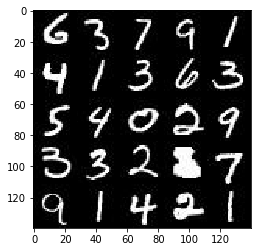

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

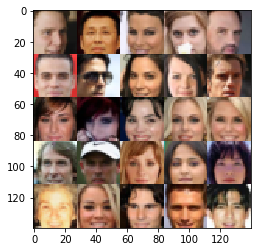

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/freeman/anaconda3/envs/machinelearning/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z_dimension = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return image, z_dimension, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
ALPHA = 0.2

def conv(layer, depth, batch_norm=True):
    layer = tf.layers.conv2d(layer, depth, 3, strides=2, padding='same')
    if batch_norm: layer = tf.layers.batch_normalization(layer, training=True)
    layer = tf.maximum(ALPHA*layer,layer) #Leaky Relu
    print('conv layer shape', layer.shape)
    return layer

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        # conv1
        layer = conv(images, 64, batch_norm=False)
        
        # conv2
        layer = conv(layer, 128)
        
        # conv3
        layer = conv(layer, 256)
        
        # flatten
        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        
        # out
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def conv_transpose(layer, depth, is_train, strides=2, batch_norm=True, leaky_relu=True):
    
    if depth: layer = tf.layers.conv2d_transpose(layer, depth, 3, strides=strides, padding='same', activation=None)
    if batch_norm: layer = tf.layers.batch_normalization(layer, training=is_train)
    if leaky_relu: 
        layer = tf.nn.relu(layer)
        layer = tf.maximum(ALPHA*layer,layer) #Leaky Relu
    print('conv_transpose layer shape', layer.shape)
    return layer


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # fc
        layer = tf.layers.dense(z, 7 * 7 * 512)

        #  reshape
        layer = tf.reshape(layer, (-1, 7, 7, 512))
        layer = conv_transpose(layer, False, is_train=is_train)

        # conv1
        layer = conv_transpose(layer, 256, is_train=is_train)

        # conv2
        layer = conv_transpose(layer, 128, is_train=is_train)


        # out
        logits = conv_transpose(layer, out_channel_dim, is_train=is_train, strides=1, batch_norm=False, leaky_relu=False)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 5)
conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
SMOOTH = 0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - SMOOTH)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 4)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """                
    
    out_channel_dim = data_shape[3]
    image, z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(image, z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    print('Input data shape', data_shape)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        global_step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                global_step += 1 
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})

                if global_step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({image: batch_images, z: batch_z})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Global Step {} Epoch {}/{}..."
                          .format(global_step ,epoch_i+1, epochs), 
                          "Discriminator Loss: {:.8f}...".format(train_loss_d),
                          "Generator Loss: {:.8f}".format(train_loss_g))

                if global_step % 200 == 0:
                    show_generator_output(sess, 9, z, out_channel_dim, data_image_mode)
                    show_generator_output(sess, show_n_images, z, out_channel_dim, data_image_mode)
                
        show_generator_output(sess, show_n_images, z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
Input data shape (60000, 28, 28, 1)
Global Step 10 Epoch 1/2... Discriminator Loss: 0.39627329... Generator Loss: 5.13576794
Global Step 20 Epoch 1/2... Discriminator Loss: 0.33940715... Generator Loss: 5.43228960
Global Step 30 Epoch 1/2... Discriminator Loss: 0.34366271... Generator Loss: 5.52102089
Global Step 40 Epoch 1/2... Discriminator Loss: 0.45737559... Generator Loss: 2.57389283
Global Step 50 Epoch 1/2... Discriminator Loss: 2.10394239... Generator Loss: 0.44294631
Global Step 60 Epoch 1/2... Discriminator Loss: 1.45412874... Generator Loss: 0.62256467
Global Step 70 Epoch 1/2... Discriminator Loss: 1.53211677... Ge

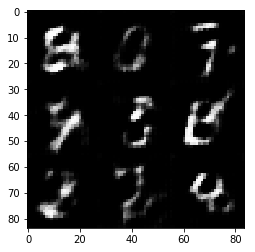

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


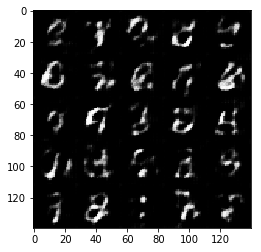

Global Step 210 Epoch 1/2... Discriminator Loss: 1.41845298... Generator Loss: 1.01735663
Global Step 220 Epoch 1/2... Discriminator Loss: 1.40582895... Generator Loss: 1.37325084
Global Step 230 Epoch 1/2... Discriminator Loss: 1.50586605... Generator Loss: 0.44153070
Global Step 240 Epoch 1/2... Discriminator Loss: 1.17399704... Generator Loss: 0.82138526
Global Step 250 Epoch 1/2... Discriminator Loss: 2.26783252... Generator Loss: 0.19929144
Global Step 260 Epoch 1/2... Discriminator Loss: 2.04513812... Generator Loss: 0.24141335
Global Step 270 Epoch 1/2... Discriminator Loss: 1.44516647... Generator Loss: 0.53207201
Global Step 280 Epoch 1/2... Discriminator Loss: 1.56174040... Generator Loss: 0.47765884
Global Step 290 Epoch 1/2... Discriminator Loss: 1.47393441... Generator Loss: 0.80002505
Global Step 300 Epoch 1/2... Discriminator Loss: 1.37277329... Generator Loss: 0.67786014
Global Step 310 Epoch 1/2... Discriminator Loss: 1.51939166... Generator Loss: 0.57872099
Global Ste

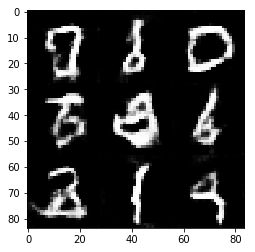

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


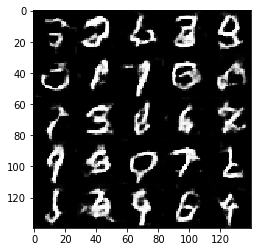

Global Step 410 Epoch 1/2... Discriminator Loss: 1.46827710... Generator Loss: 0.51812190
Global Step 420 Epoch 1/2... Discriminator Loss: 1.52193475... Generator Loss: 0.64475399
Global Step 430 Epoch 1/2... Discriminator Loss: 1.50890827... Generator Loss: 0.52179205
Global Step 440 Epoch 1/2... Discriminator Loss: 1.23946321... Generator Loss: 1.20253158
Global Step 450 Epoch 1/2... Discriminator Loss: 1.22128892... Generator Loss: 1.02946138
Global Step 460 Epoch 1/2... Discriminator Loss: 1.30802047... Generator Loss: 1.44711328
Global Step 470 Epoch 1/2... Discriminator Loss: 1.27868605... Generator Loss: 0.73615468
Global Step 480 Epoch 1/2... Discriminator Loss: 1.36945200... Generator Loss: 0.91972828
Global Step 490 Epoch 1/2... Discriminator Loss: 1.23054504... Generator Loss: 0.87940156
Global Step 500 Epoch 1/2... Discriminator Loss: 1.43088531... Generator Loss: 1.47434652
Global Step 510 Epoch 1/2... Discriminator Loss: 1.19033408... Generator Loss: 0.95437646
Global Ste

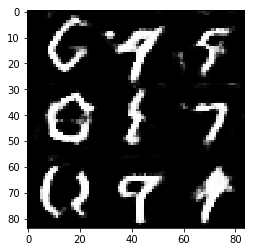

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


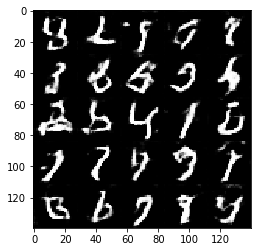

Global Step 610 Epoch 1/2... Discriminator Loss: 1.26408076... Generator Loss: 0.90760285
Global Step 620 Epoch 1/2... Discriminator Loss: 1.39242291... Generator Loss: 0.57640558
Global Step 630 Epoch 1/2... Discriminator Loss: 1.28127646... Generator Loss: 0.80167449
Global Step 640 Epoch 1/2... Discriminator Loss: 1.32123244... Generator Loss: 0.59165812
Global Step 650 Epoch 1/2... Discriminator Loss: 1.27416027... Generator Loss: 0.75030100
Global Step 660 Epoch 1/2... Discriminator Loss: 1.08240318... Generator Loss: 1.42394519
Global Step 670 Epoch 1/2... Discriminator Loss: 1.28864896... Generator Loss: 0.68743432
Global Step 680 Epoch 1/2... Discriminator Loss: 1.38958681... Generator Loss: 0.55655766
Global Step 690 Epoch 1/2... Discriminator Loss: 1.28682935... Generator Loss: 0.77559471
Global Step 700 Epoch 1/2... Discriminator Loss: 2.94151425... Generator Loss: 3.42282581
Global Step 710 Epoch 1/2... Discriminator Loss: 1.49892855... Generator Loss: 0.48042947
Global Ste

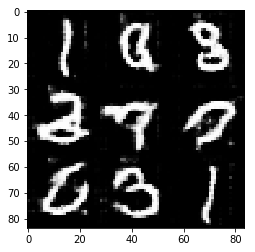

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


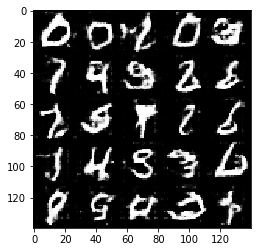

Global Step 810 Epoch 1/2... Discriminator Loss: 1.46717262... Generator Loss: 0.46336496
Global Step 820 Epoch 1/2... Discriminator Loss: 2.54122019... Generator Loss: 2.90826750
Global Step 830 Epoch 1/2... Discriminator Loss: 1.54564166... Generator Loss: 0.43718684
Global Step 840 Epoch 1/2... Discriminator Loss: 1.37936211... Generator Loss: 0.59574294
Global Step 850 Epoch 1/2... Discriminator Loss: 1.44808996... Generator Loss: 0.43813202
Global Step 860 Epoch 1/2... Discriminator Loss: 1.24180520... Generator Loss: 0.84108323
Global Step 870 Epoch 1/2... Discriminator Loss: 1.59088457... Generator Loss: 0.38858849
Global Step 880 Epoch 1/2... Discriminator Loss: 1.15274763... Generator Loss: 0.74846375
Global Step 890 Epoch 1/2... Discriminator Loss: 1.65101194... Generator Loss: 1.84762383
Global Step 900 Epoch 1/2... Discriminator Loss: 1.29573739... Generator Loss: 0.66041112
Global Step 910 Epoch 1/2... Discriminator Loss: 1.45064139... Generator Loss: 0.49363700
Global Ste

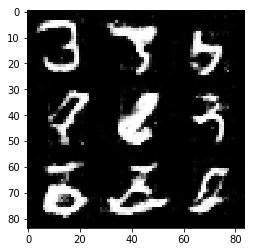

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


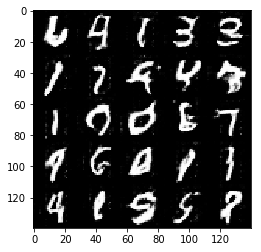

Global Step 1010 Epoch 1/2... Discriminator Loss: 1.30411029... Generator Loss: 0.57593220
Global Step 1020 Epoch 1/2... Discriminator Loss: 1.19788754... Generator Loss: 0.95294029
Global Step 1030 Epoch 1/2... Discriminator Loss: 2.16994619... Generator Loss: 0.19710463
Global Step 1040 Epoch 1/2... Discriminator Loss: 1.43084860... Generator Loss: 0.49482280
Global Step 1050 Epoch 1/2... Discriminator Loss: 1.27952647... Generator Loss: 0.69363517
Global Step 1060 Epoch 1/2... Discriminator Loss: 1.30108690... Generator Loss: 0.63512433
Global Step 1070 Epoch 1/2... Discriminator Loss: 1.05951953... Generator Loss: 1.29559040
Global Step 1080 Epoch 1/2... Discriminator Loss: 1.49324417... Generator Loss: 0.48191026
Global Step 1090 Epoch 1/2... Discriminator Loss: 1.35109508... Generator Loss: 0.66746199
Global Step 1100 Epoch 1/2... Discriminator Loss: 1.62882280... Generator Loss: 0.37362063
Global Step 1110 Epoch 1/2... Discriminator Loss: 1.27620983... Generator Loss: 0.62354779

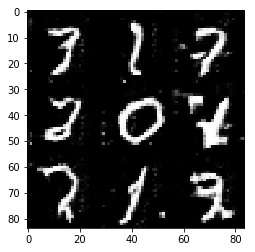

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


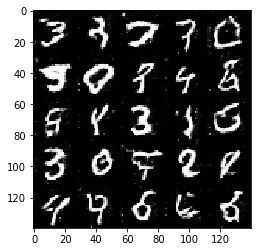

Global Step 1210 Epoch 1/2... Discriminator Loss: 1.47512305... Generator Loss: 2.59570074
Global Step 1220 Epoch 1/2... Discriminator Loss: 1.19161701... Generator Loss: 0.77438247
Global Step 1230 Epoch 1/2... Discriminator Loss: 1.24031293... Generator Loss: 1.60111558
Global Step 1240 Epoch 1/2... Discriminator Loss: 1.28549862... Generator Loss: 0.88361740
Global Step 1250 Epoch 1/2... Discriminator Loss: 1.25336134... Generator Loss: 0.80120516
Global Step 1260 Epoch 1/2... Discriminator Loss: 1.31522369... Generator Loss: 0.67072821
Global Step 1270 Epoch 1/2... Discriminator Loss: 1.14821827... Generator Loss: 1.03702736
Global Step 1280 Epoch 1/2... Discriminator Loss: 1.97776604... Generator Loss: 0.26755697
Global Step 1290 Epoch 1/2... Discriminator Loss: 1.12029803... Generator Loss: 0.75146717
Global Step 1300 Epoch 1/2... Discriminator Loss: 1.16930139... Generator Loss: 0.68637574
Global Step 1310 Epoch 1/2... Discriminator Loss: 1.16480303... Generator Loss: 0.85650563

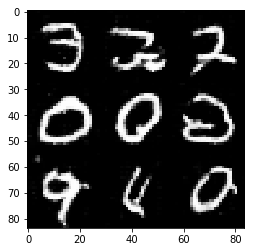

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


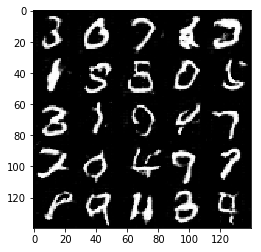

Global Step 1410 Epoch 1/2... Discriminator Loss: 1.33704019... Generator Loss: 0.88119143
Global Step 1420 Epoch 1/2... Discriminator Loss: 1.39808059... Generator Loss: 0.55284756
Global Step 1430 Epoch 1/2... Discriminator Loss: 1.14089501... Generator Loss: 0.72431195
Global Step 1440 Epoch 1/2... Discriminator Loss: 1.33098793... Generator Loss: 0.64868784
Global Step 1450 Epoch 1/2... Discriminator Loss: 1.27926826... Generator Loss: 0.58153629
Global Step 1460 Epoch 1/2... Discriminator Loss: 0.91722035... Generator Loss: 1.13293171
Global Step 1470 Epoch 1/2... Discriminator Loss: 1.48383069... Generator Loss: 0.43963841
Global Step 1480 Epoch 1/2... Discriminator Loss: 0.98668683... Generator Loss: 1.10288286
Global Step 1490 Epoch 1/2... Discriminator Loss: 1.84336472... Generator Loss: 0.35027811
Global Step 1500 Epoch 1/2... Discriminator Loss: 1.43206418... Generator Loss: 0.49537510
Global Step 1510 Epoch 1/2... Discriminator Loss: 1.08282566... Generator Loss: 0.76877058

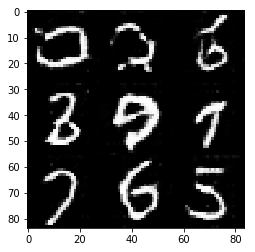

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


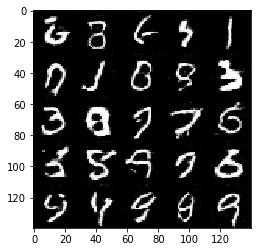

Global Step 1610 Epoch 1/2... Discriminator Loss: 1.57208204... Generator Loss: 0.44759893
Global Step 1620 Epoch 1/2... Discriminator Loss: 1.16791320... Generator Loss: 1.28923941
Global Step 1630 Epoch 1/2... Discriminator Loss: 0.99831682... Generator Loss: 0.97300839
Global Step 1640 Epoch 1/2... Discriminator Loss: 0.99161363... Generator Loss: 1.04693794
Global Step 1650 Epoch 1/2... Discriminator Loss: 1.01617336... Generator Loss: 1.19272542
Global Step 1660 Epoch 1/2... Discriminator Loss: 1.28551865... Generator Loss: 0.55805963
Global Step 1670 Epoch 1/2... Discriminator Loss: 1.24915242... Generator Loss: 0.61778361
Global Step 1680 Epoch 1/2... Discriminator Loss: 0.99712265... Generator Loss: 1.04626274
Global Step 1690 Epoch 1/2... Discriminator Loss: 1.05485201... Generator Loss: 0.83660090
Global Step 1700 Epoch 1/2... Discriminator Loss: 1.08050156... Generator Loss: 0.83504587
Global Step 1710 Epoch 1/2... Discriminator Loss: 1.01616943... Generator Loss: 0.91422808

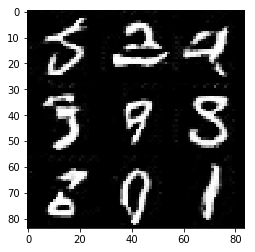

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


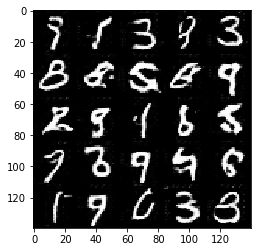

Global Step 1810 Epoch 1/2... Discriminator Loss: 1.35337687... Generator Loss: 0.57871598
Global Step 1820 Epoch 1/2... Discriminator Loss: 0.99740654... Generator Loss: 0.86258948
Global Step 1830 Epoch 1/2... Discriminator Loss: 1.49635148... Generator Loss: 0.48156032
Global Step 1840 Epoch 1/2... Discriminator Loss: 0.87054616... Generator Loss: 1.27947187
Global Step 1850 Epoch 1/2... Discriminator Loss: 1.45690274... Generator Loss: 0.53405374
Global Step 1860 Epoch 1/2... Discriminator Loss: 1.16146505... Generator Loss: 0.76338363
Global Step 1870 Epoch 1/2... Discriminator Loss: 0.97853482... Generator Loss: 1.16354489
Global Step 1880 Epoch 2/2... Discriminator Loss: 1.27629912... Generator Loss: 0.64859146
Global Step 1890 Epoch 2/2... Discriminator Loss: 1.13691795... Generator Loss: 0.74472630
Global Step 1900 Epoch 2/2... Discriminator Loss: 0.78139615... Generator Loss: 1.43919301
Global Step 1910 Epoch 2/2... Discriminator Loss: 1.31351995... Generator Loss: 0.59613007

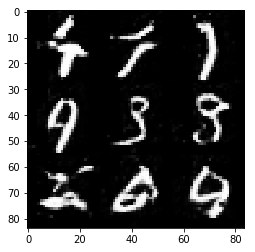

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


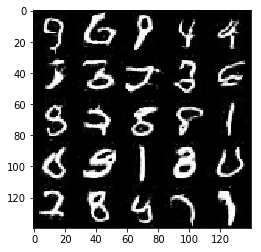

Global Step 2010 Epoch 2/2... Discriminator Loss: 1.48825288... Generator Loss: 0.48882324
Global Step 2020 Epoch 2/2... Discriminator Loss: 1.15778458... Generator Loss: 0.72604424
Global Step 2030 Epoch 2/2... Discriminator Loss: 1.02526820... Generator Loss: 1.78545570
Global Step 2040 Epoch 2/2... Discriminator Loss: 1.24538445... Generator Loss: 0.67112714
Global Step 2050 Epoch 2/2... Discriminator Loss: 0.93625045... Generator Loss: 1.13021529
Global Step 2060 Epoch 2/2... Discriminator Loss: 1.28833747... Generator Loss: 0.63594413
Global Step 2070 Epoch 2/2... Discriminator Loss: 0.96519506... Generator Loss: 1.29609752
Global Step 2080 Epoch 2/2... Discriminator Loss: 1.08025241... Generator Loss: 0.89787883
Global Step 2090 Epoch 2/2... Discriminator Loss: 1.41410351... Generator Loss: 0.56249005
Global Step 2100 Epoch 2/2... Discriminator Loss: 1.11950171... Generator Loss: 0.80298734
Global Step 2110 Epoch 2/2... Discriminator Loss: 0.91830099... Generator Loss: 1.64551795

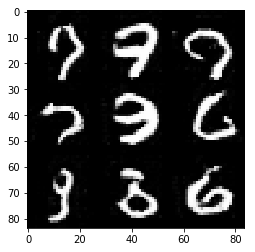

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


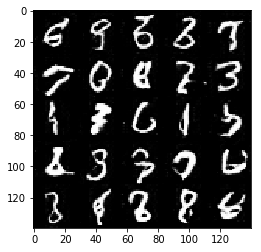

Global Step 2210 Epoch 2/2... Discriminator Loss: 0.92810571... Generator Loss: 1.08055711
Global Step 2220 Epoch 2/2... Discriminator Loss: 1.32370257... Generator Loss: 0.54481387
Global Step 2230 Epoch 2/2... Discriminator Loss: 1.29570961... Generator Loss: 0.60895133
Global Step 2240 Epoch 2/2... Discriminator Loss: 1.34317648... Generator Loss: 0.55698693
Global Step 2250 Epoch 2/2... Discriminator Loss: 0.90719926... Generator Loss: 1.07079065
Global Step 2260 Epoch 2/2... Discriminator Loss: 0.94279385... Generator Loss: 1.06909442
Global Step 2270 Epoch 2/2... Discriminator Loss: 1.58771336... Generator Loss: 2.12522101
Global Step 2280 Epoch 2/2... Discriminator Loss: 1.11593199... Generator Loss: 1.20906663
Global Step 2290 Epoch 2/2... Discriminator Loss: 1.26096272... Generator Loss: 1.70216155
Global Step 2300 Epoch 2/2... Discriminator Loss: 1.12248182... Generator Loss: 1.58389711
Global Step 2310 Epoch 2/2... Discriminator Loss: 1.46103489... Generator Loss: 0.60889030

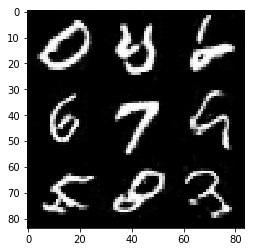

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


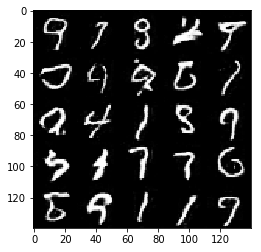

Global Step 2410 Epoch 2/2... Discriminator Loss: 0.91833866... Generator Loss: 1.08739114
Global Step 2420 Epoch 2/2... Discriminator Loss: 1.16575575... Generator Loss: 1.97458220
Global Step 2430 Epoch 2/2... Discriminator Loss: 0.95413411... Generator Loss: 0.94108921
Global Step 2440 Epoch 2/2... Discriminator Loss: 1.17250693... Generator Loss: 0.72634137
Global Step 2450 Epoch 2/2... Discriminator Loss: 0.91386706... Generator Loss: 1.51498520
Global Step 2460 Epoch 2/2... Discriminator Loss: 1.23994780... Generator Loss: 0.64948571
Global Step 2470 Epoch 2/2... Discriminator Loss: 1.48136139... Generator Loss: 0.54744315
Global Step 2480 Epoch 2/2... Discriminator Loss: 1.08093750... Generator Loss: 0.79749602
Global Step 2490 Epoch 2/2... Discriminator Loss: 0.94213802... Generator Loss: 1.16355681
Global Step 2500 Epoch 2/2... Discriminator Loss: 0.99772751... Generator Loss: 1.02493775
Global Step 2510 Epoch 2/2... Discriminator Loss: 1.07063293... Generator Loss: 1.23330605

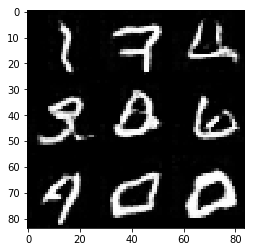

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


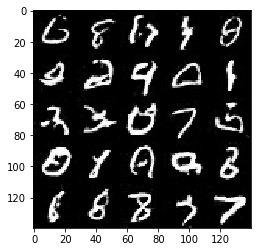

Global Step 2610 Epoch 2/2... Discriminator Loss: 1.09766710... Generator Loss: 0.76106143
Global Step 2620 Epoch 2/2... Discriminator Loss: 0.88322634... Generator Loss: 1.35035610
Global Step 2630 Epoch 2/2... Discriminator Loss: 1.52212429... Generator Loss: 0.98788345
Global Step 2640 Epoch 2/2... Discriminator Loss: 0.91113007... Generator Loss: 1.62693977
Global Step 2650 Epoch 2/2... Discriminator Loss: 1.05774093... Generator Loss: 0.83921313
Global Step 2660 Epoch 2/2... Discriminator Loss: 1.10682201... Generator Loss: 0.82425809
Global Step 2670 Epoch 2/2... Discriminator Loss: 0.98029792... Generator Loss: 1.50385416
Global Step 2680 Epoch 2/2... Discriminator Loss: 1.07822168... Generator Loss: 0.86140597
Global Step 2690 Epoch 2/2... Discriminator Loss: 0.88601720... Generator Loss: 1.10314679
Global Step 2700 Epoch 2/2... Discriminator Loss: 1.03946626... Generator Loss: 0.98430222
Global Step 2710 Epoch 2/2... Discriminator Loss: 1.01411402... Generator Loss: 1.11668110

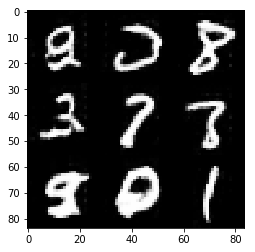

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


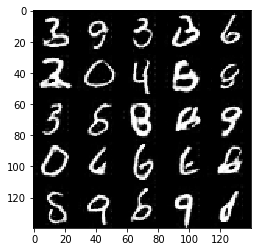

Global Step 2810 Epoch 2/2... Discriminator Loss: 1.00044310... Generator Loss: 1.75947189
Global Step 2820 Epoch 2/2... Discriminator Loss: 0.96433759... Generator Loss: 1.01090503
Global Step 2830 Epoch 2/2... Discriminator Loss: 1.10409963... Generator Loss: 1.77507186
Global Step 2840 Epoch 2/2... Discriminator Loss: 0.86373466... Generator Loss: 1.82247972
Global Step 2850 Epoch 2/2... Discriminator Loss: 1.04131782... Generator Loss: 1.31069446
Global Step 2860 Epoch 2/2... Discriminator Loss: 1.20096326... Generator Loss: 1.03011775
Global Step 2870 Epoch 2/2... Discriminator Loss: 1.61912346... Generator Loss: 0.44481635
Global Step 2880 Epoch 2/2... Discriminator Loss: 1.88454342... Generator Loss: 0.33181953
Global Step 2890 Epoch 2/2... Discriminator Loss: 1.32044339... Generator Loss: 0.64193022
Global Step 2900 Epoch 2/2... Discriminator Loss: 0.79170537... Generator Loss: 1.68428051
Global Step 2910 Epoch 2/2... Discriminator Loss: 1.07452905... Generator Loss: 0.84173656

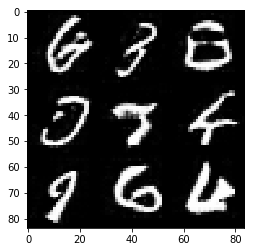

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


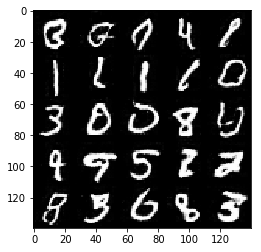

Global Step 3010 Epoch 2/2... Discriminator Loss: 1.52876985... Generator Loss: 0.50791281
Global Step 3020 Epoch 2/2... Discriminator Loss: 0.97556794... Generator Loss: 0.99886179
Global Step 3030 Epoch 2/2... Discriminator Loss: 1.32409060... Generator Loss: 1.13702321
Global Step 3040 Epoch 2/2... Discriminator Loss: 1.10695791... Generator Loss: 0.81653583
Global Step 3050 Epoch 2/2... Discriminator Loss: 0.99756479... Generator Loss: 0.94035941
Global Step 3060 Epoch 2/2... Discriminator Loss: 1.81788564... Generator Loss: 0.36041003
Global Step 3070 Epoch 2/2... Discriminator Loss: 1.50561023... Generator Loss: 0.52506673
Global Step 3080 Epoch 2/2... Discriminator Loss: 1.09229422... Generator Loss: 0.85689873
Global Step 3090 Epoch 2/2... Discriminator Loss: 1.06493974... Generator Loss: 0.88452679
Global Step 3100 Epoch 2/2... Discriminator Loss: 0.66795385... Generator Loss: 1.71734285
Global Step 3110 Epoch 2/2... Discriminator Loss: 0.73165005... Generator Loss: 1.43187785

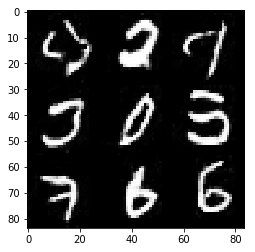

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


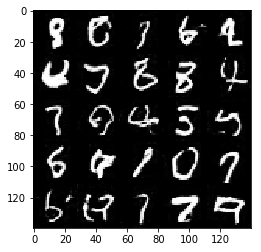

Global Step 3210 Epoch 2/2... Discriminator Loss: 1.30693698... Generator Loss: 0.60887378
Global Step 3220 Epoch 2/2... Discriminator Loss: 0.99165165... Generator Loss: 1.85808766
Global Step 3230 Epoch 2/2... Discriminator Loss: 1.06918609... Generator Loss: 0.93284154
Global Step 3240 Epoch 2/2... Discriminator Loss: 1.01793444... Generator Loss: 1.00412321
Global Step 3250 Epoch 2/2... Discriminator Loss: 0.94410455... Generator Loss: 0.95580542
Global Step 3260 Epoch 2/2... Discriminator Loss: 0.78922069... Generator Loss: 1.38364041
Global Step 3270 Epoch 2/2... Discriminator Loss: 0.87653232... Generator Loss: 1.14801455
Global Step 3280 Epoch 2/2... Discriminator Loss: 0.92164952... Generator Loss: 1.70843840
Global Step 3290 Epoch 2/2... Discriminator Loss: 1.92659807... Generator Loss: 0.28921551
Global Step 3300 Epoch 2/2... Discriminator Loss: 0.86340189... Generator Loss: 1.18956769
Global Step 3310 Epoch 2/2... Discriminator Loss: 1.32494164... Generator Loss: 0.63102901

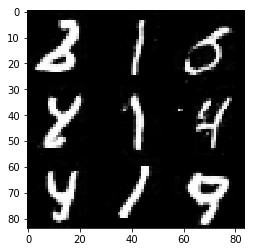

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


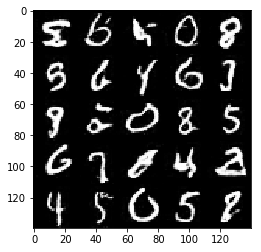

Global Step 3410 Epoch 2/2... Discriminator Loss: 0.79628396... Generator Loss: 1.55219841
Global Step 3420 Epoch 2/2... Discriminator Loss: 0.97509372... Generator Loss: 1.16641521
Global Step 3430 Epoch 2/2... Discriminator Loss: 0.94702911... Generator Loss: 1.11433983
Global Step 3440 Epoch 2/2... Discriminator Loss: 1.19117713... Generator Loss: 0.71997160
Global Step 3450 Epoch 2/2... Discriminator Loss: 0.95504022... Generator Loss: 1.38599360
Global Step 3460 Epoch 2/2... Discriminator Loss: 1.37051666... Generator Loss: 0.62017614
Global Step 3470 Epoch 2/2... Discriminator Loss: 1.22873807... Generator Loss: 0.66507351
Global Step 3480 Epoch 2/2... Discriminator Loss: 0.92756212... Generator Loss: 1.22872221
Global Step 3490 Epoch 2/2... Discriminator Loss: 1.04510510... Generator Loss: 0.97004998
Global Step 3500 Epoch 2/2... Discriminator Loss: 0.90679514... Generator Loss: 1.03887725
Global Step 3510 Epoch 2/2... Discriminator Loss: 1.22628820... Generator Loss: 0.68599021

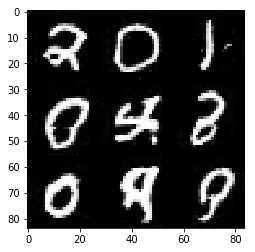

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 1)


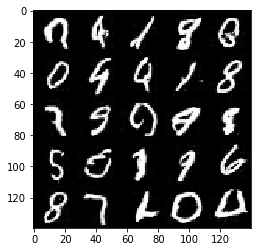

Global Step 3610 Epoch 2/2... Discriminator Loss: 1.19246209... Generator Loss: 0.70323277
Global Step 3620 Epoch 2/2... Discriminator Loss: 1.42583036... Generator Loss: 0.64918685
Global Step 3630 Epoch 2/2... Discriminator Loss: 1.24241519... Generator Loss: 0.65811723
Global Step 3640 Epoch 2/2... Discriminator Loss: 0.97992253... Generator Loss: 1.52526689
Global Step 3650 Epoch 2/2... Discriminator Loss: 1.10965419... Generator Loss: 0.86212069
Global Step 3660 Epoch 2/2... Discriminator Loss: 0.96642709... Generator Loss: 1.06063139
Global Step 3670 Epoch 2/2... Discriminator Loss: 0.80002570... Generator Loss: 1.90897954
Global Step 3680 Epoch 2/2... Discriminator Loss: 1.20547223... Generator Loss: 1.80430412
Global Step 3690 Epoch 2/2... Discriminator Loss: 1.04362750... Generator Loss: 0.94676137
Global Step 3700 Epoch 2/2... Discriminator Loss: 0.84833479... Generator Loss: 1.46987295
Global Step 3710 Epoch 2/2... Discriminator Loss: 1.32771194... Generator Loss: 2.81233931

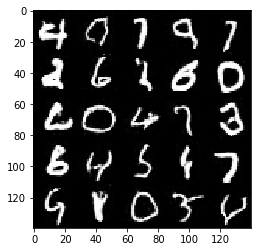

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
conv layer shape (?, 14, 14, 64)
conv layer shape (?, 7, 7, 128)
conv layer shape (?, 4, 4, 256)
Input data shape (202599, 28, 28, 3)
Global Step 10 Epoch 1/1... Discriminator Loss: 2.53787732... Generator Loss: 0.24116999
Global Step 20 Epoch 1/1... Discriminator Loss: 1.06944823... Generator Loss: 14.12898254
Global Step 30 Epoch 1/1... Discriminator Loss: 3.15295339... Generator Loss: 0.12218866
Global Step 40 Epoch 1/1... Discriminator Loss: 0.79813164... Generator Loss: 1.74835730
Global Step 50 Epoch 1/1... Discriminator Loss: 1.13982344... Generator Loss: 2.46094871
Global Step 60 Epoch 1/1... Discriminator Loss: 1.02104115... Generator Loss: 1.85791898
Global Step 70 Epoch 1/1... Discriminator Loss: 0.98013562... 

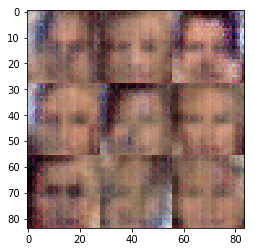

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


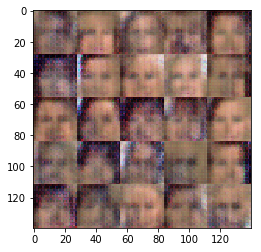

Global Step 210 Epoch 1/1... Discriminator Loss: 1.55188489... Generator Loss: 0.55996704
Global Step 220 Epoch 1/1... Discriminator Loss: 1.39900088... Generator Loss: 1.34464550
Global Step 230 Epoch 1/1... Discriminator Loss: 1.49267149... Generator Loss: 0.61567670
Global Step 240 Epoch 1/1... Discriminator Loss: 1.34450340... Generator Loss: 0.69034863
Global Step 250 Epoch 1/1... Discriminator Loss: 1.43290794... Generator Loss: 0.69951314
Global Step 260 Epoch 1/1... Discriminator Loss: 1.50616050... Generator Loss: 0.87275738
Global Step 270 Epoch 1/1... Discriminator Loss: 1.81802166... Generator Loss: 0.34312218
Global Step 280 Epoch 1/1... Discriminator Loss: 1.54405856... Generator Loss: 0.43067273
Global Step 290 Epoch 1/1... Discriminator Loss: 1.32702136... Generator Loss: 1.33096504
Global Step 300 Epoch 1/1... Discriminator Loss: 1.52565253... Generator Loss: 1.25483966
Global Step 310 Epoch 1/1... Discriminator Loss: 1.05274904... Generator Loss: 1.29320014
Global Ste

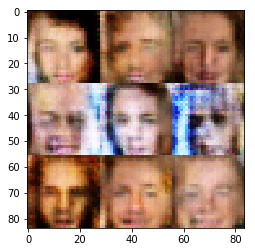

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


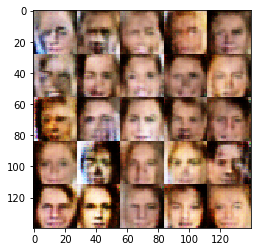

Global Step 410 Epoch 1/1... Discriminator Loss: 1.57467461... Generator Loss: 0.43937317
Global Step 420 Epoch 1/1... Discriminator Loss: 1.45128155... Generator Loss: 0.78770816
Global Step 430 Epoch 1/1... Discriminator Loss: 1.33225441... Generator Loss: 0.73762327
Global Step 440 Epoch 1/1... Discriminator Loss: 1.14322901... Generator Loss: 1.29741383
Global Step 450 Epoch 1/1... Discriminator Loss: 1.48848617... Generator Loss: 1.10726380
Global Step 460 Epoch 1/1... Discriminator Loss: 1.52010250... Generator Loss: 0.50637811
Global Step 470 Epoch 1/1... Discriminator Loss: 1.10791624... Generator Loss: 0.73639590
Global Step 480 Epoch 1/1... Discriminator Loss: 1.34801340... Generator Loss: 0.61152983
Global Step 490 Epoch 1/1... Discriminator Loss: 1.94222271... Generator Loss: 0.26315337
Global Step 500 Epoch 1/1... Discriminator Loss: 1.10158157... Generator Loss: 1.63494039
Global Step 510 Epoch 1/1... Discriminator Loss: 1.71446264... Generator Loss: 0.33561656
Global Ste

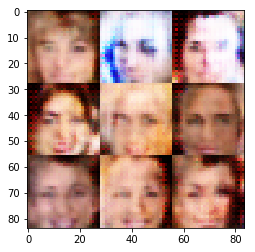

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


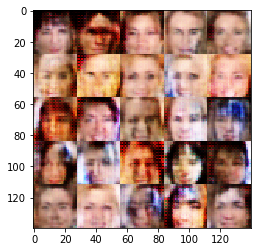

Global Step 610 Epoch 1/1... Discriminator Loss: 1.26466846... Generator Loss: 0.79464871
Global Step 620 Epoch 1/1... Discriminator Loss: 1.19910848... Generator Loss: 1.19383860
Global Step 630 Epoch 1/1... Discriminator Loss: 1.38929367... Generator Loss: 0.63584805
Global Step 640 Epoch 1/1... Discriminator Loss: 1.49069273... Generator Loss: 0.80913484
Global Step 650 Epoch 1/1... Discriminator Loss: 1.28026676... Generator Loss: 1.30760384
Global Step 660 Epoch 1/1... Discriminator Loss: 1.30817127... Generator Loss: 0.77481341
Global Step 670 Epoch 1/1... Discriminator Loss: 1.49161732... Generator Loss: 1.02697277
Global Step 680 Epoch 1/1... Discriminator Loss: 1.21149111... Generator Loss: 0.73860502
Global Step 690 Epoch 1/1... Discriminator Loss: 1.25112844... Generator Loss: 1.01406002
Global Step 700 Epoch 1/1... Discriminator Loss: 1.19093823... Generator Loss: 0.83294362
Global Step 710 Epoch 1/1... Discriminator Loss: 1.32889795... Generator Loss: 0.77489352
Global Ste

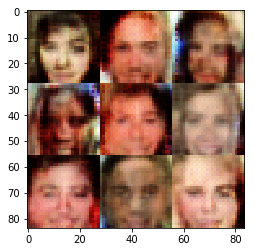

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


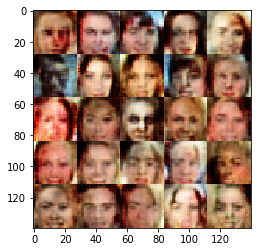

Global Step 810 Epoch 1/1... Discriminator Loss: 1.71935570... Generator Loss: 0.32929343
Global Step 820 Epoch 1/1... Discriminator Loss: 1.43355846... Generator Loss: 1.24148715
Global Step 830 Epoch 1/1... Discriminator Loss: 1.48414302... Generator Loss: 0.45965523
Global Step 840 Epoch 1/1... Discriminator Loss: 1.23631001... Generator Loss: 0.71755052
Global Step 850 Epoch 1/1... Discriminator Loss: 1.31402183... Generator Loss: 0.82315564
Global Step 860 Epoch 1/1... Discriminator Loss: 1.44324422... Generator Loss: 0.90614593
Global Step 870 Epoch 1/1... Discriminator Loss: 1.61937237... Generator Loss: 0.37962586
Global Step 880 Epoch 1/1... Discriminator Loss: 1.38538980... Generator Loss: 0.60742819
Global Step 890 Epoch 1/1... Discriminator Loss: 1.31316447... Generator Loss: 1.02323389
Global Step 900 Epoch 1/1... Discriminator Loss: 1.28420424... Generator Loss: 1.21005380
Global Step 910 Epoch 1/1... Discriminator Loss: 1.50055957... Generator Loss: 0.56313229
Global Ste

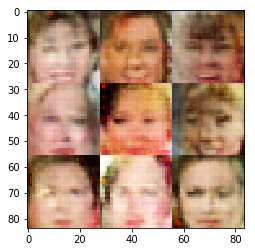

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


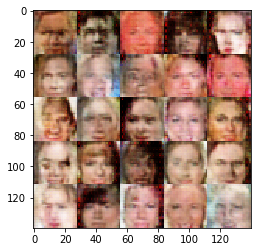

Global Step 1010 Epoch 1/1... Discriminator Loss: 1.50936151... Generator Loss: 0.43292311
Global Step 1020 Epoch 1/1... Discriminator Loss: 1.35394382... Generator Loss: 0.54586190
Global Step 1030 Epoch 1/1... Discriminator Loss: 1.19051373... Generator Loss: 0.97830862
Global Step 1040 Epoch 1/1... Discriminator Loss: 1.37838066... Generator Loss: 0.63290459
Global Step 1050 Epoch 1/1... Discriminator Loss: 1.15465164... Generator Loss: 1.07139063
Global Step 1060 Epoch 1/1... Discriminator Loss: 1.41985178... Generator Loss: 0.57744575
Global Step 1070 Epoch 1/1... Discriminator Loss: 1.16157019... Generator Loss: 0.99574411
Global Step 1080 Epoch 1/1... Discriminator Loss: 1.30235100... Generator Loss: 0.59768629
Global Step 1090 Epoch 1/1... Discriminator Loss: 1.44751525... Generator Loss: 1.22648370
Global Step 1100 Epoch 1/1... Discriminator Loss: 1.18990445... Generator Loss: 1.14015818
Global Step 1110 Epoch 1/1... Discriminator Loss: 1.34481764... Generator Loss: 0.82649446

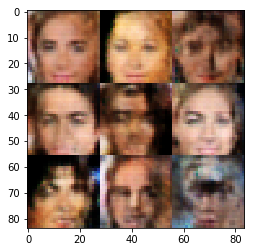

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


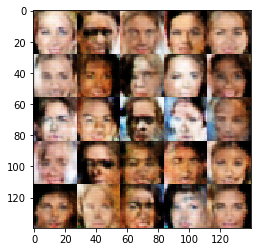

Global Step 1210 Epoch 1/1... Discriminator Loss: 1.34029973... Generator Loss: 0.91648042
Global Step 1220 Epoch 1/1... Discriminator Loss: 1.28452766... Generator Loss: 0.73569107
Global Step 1230 Epoch 1/1... Discriminator Loss: 1.47397089... Generator Loss: 0.76008928
Global Step 1240 Epoch 1/1... Discriminator Loss: 1.17622077... Generator Loss: 0.75522184
Global Step 1250 Epoch 1/1... Discriminator Loss: 1.44918489... Generator Loss: 0.51681852
Global Step 1260 Epoch 1/1... Discriminator Loss: 1.34125829... Generator Loss: 0.96406645
Global Step 1270 Epoch 1/1... Discriminator Loss: 1.08630037... Generator Loss: 0.88406610
Global Step 1280 Epoch 1/1... Discriminator Loss: 1.31849682... Generator Loss: 0.66733354
Global Step 1290 Epoch 1/1... Discriminator Loss: 1.36588430... Generator Loss: 0.92902732
Global Step 1300 Epoch 1/1... Discriminator Loss: 1.60995412... Generator Loss: 0.81296909
Global Step 1310 Epoch 1/1... Discriminator Loss: 1.46456528... Generator Loss: 0.77799499

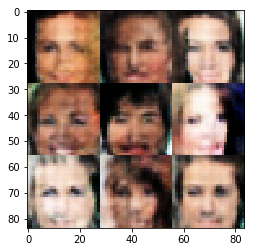

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


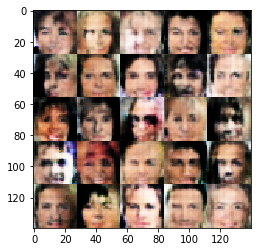

Global Step 1410 Epoch 1/1... Discriminator Loss: 1.50072026... Generator Loss: 0.42416880
Global Step 1420 Epoch 1/1... Discriminator Loss: 1.40282536... Generator Loss: 1.00548685
Global Step 1430 Epoch 1/1... Discriminator Loss: 1.53003132... Generator Loss: 0.69020307
Global Step 1440 Epoch 1/1... Discriminator Loss: 1.49550915... Generator Loss: 0.51388299
Global Step 1450 Epoch 1/1... Discriminator Loss: 1.42388988... Generator Loss: 0.72080052
Global Step 1460 Epoch 1/1... Discriminator Loss: 0.98508215... Generator Loss: 1.06244111
Global Step 1470 Epoch 1/1... Discriminator Loss: 1.38803291... Generator Loss: 0.66376787
Global Step 1480 Epoch 1/1... Discriminator Loss: 1.55971575... Generator Loss: 0.57740271
Global Step 1490 Epoch 1/1... Discriminator Loss: 1.50048864... Generator Loss: 0.69595134
Global Step 1500 Epoch 1/1... Discriminator Loss: 1.49952793... Generator Loss: 0.75402933
Global Step 1510 Epoch 1/1... Discriminator Loss: 1.42804551... Generator Loss: 0.75000811

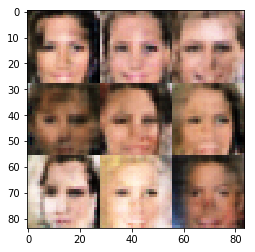

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


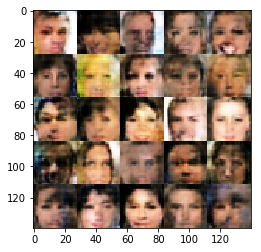

Global Step 1610 Epoch 1/1... Discriminator Loss: 1.34767032... Generator Loss: 0.87232465
Global Step 1620 Epoch 1/1... Discriminator Loss: 1.43195486... Generator Loss: 0.76927149
Global Step 1630 Epoch 1/1... Discriminator Loss: 1.40388870... Generator Loss: 0.62087995
Global Step 1640 Epoch 1/1... Discriminator Loss: 1.50202084... Generator Loss: 0.66857457
Global Step 1650 Epoch 1/1... Discriminator Loss: 1.40849340... Generator Loss: 0.75154567
Global Step 1660 Epoch 1/1... Discriminator Loss: 1.48948193... Generator Loss: 0.70806754
Global Step 1670 Epoch 1/1... Discriminator Loss: 1.46050084... Generator Loss: 0.62817013
Global Step 1680 Epoch 1/1... Discriminator Loss: 1.34314585... Generator Loss: 0.85599017
Global Step 1690 Epoch 1/1... Discriminator Loss: 1.38013601... Generator Loss: 0.78732908
Global Step 1700 Epoch 1/1... Discriminator Loss: 1.38817167... Generator Loss: 0.75448668
Global Step 1710 Epoch 1/1... Discriminator Loss: 1.28109026... Generator Loss: 0.86001813

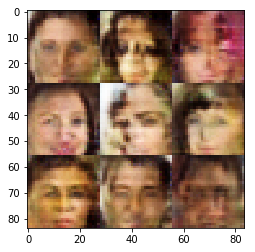

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


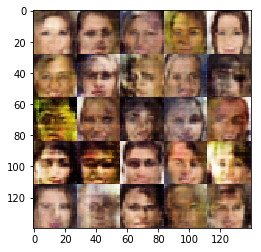

Global Step 1810 Epoch 1/1... Discriminator Loss: 1.47275949... Generator Loss: 0.64313608
Global Step 1820 Epoch 1/1... Discriminator Loss: 1.47652602... Generator Loss: 0.63901722
Global Step 1830 Epoch 1/1... Discriminator Loss: 1.50531554... Generator Loss: 0.79267311
Global Step 1840 Epoch 1/1... Discriminator Loss: 1.33439732... Generator Loss: 0.79610699
Global Step 1850 Epoch 1/1... Discriminator Loss: 1.58568072... Generator Loss: 0.64677179
Global Step 1860 Epoch 1/1... Discriminator Loss: 1.45463574... Generator Loss: 0.77435565
Global Step 1870 Epoch 1/1... Discriminator Loss: 1.49809849... Generator Loss: 0.71933365
Global Step 1880 Epoch 1/1... Discriminator Loss: 1.41691816... Generator Loss: 0.79396391
Global Step 1890 Epoch 1/1... Discriminator Loss: 1.45266485... Generator Loss: 0.80420166
Global Step 1900 Epoch 1/1... Discriminator Loss: 1.50283217... Generator Loss: 0.75052291
Global Step 1910 Epoch 1/1... Discriminator Loss: 1.36543906... Generator Loss: 0.70878696

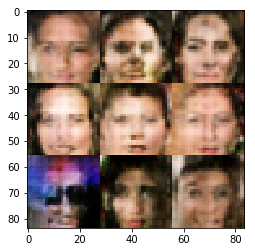

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


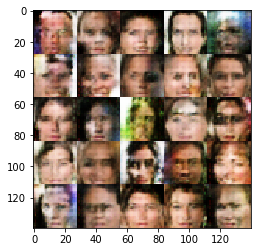

Global Step 2010 Epoch 1/1... Discriminator Loss: 1.47304010... Generator Loss: 0.68865216
Global Step 2020 Epoch 1/1... Discriminator Loss: 1.44941711... Generator Loss: 0.71660018
Global Step 2030 Epoch 1/1... Discriminator Loss: 1.57789397... Generator Loss: 0.75281358
Global Step 2040 Epoch 1/1... Discriminator Loss: 1.45864630... Generator Loss: 0.64897358
Global Step 2050 Epoch 1/1... Discriminator Loss: 1.35620868... Generator Loss: 0.87854135
Global Step 2060 Epoch 1/1... Discriminator Loss: 1.46400964... Generator Loss: 0.65906721
Global Step 2070 Epoch 1/1... Discriminator Loss: 1.49043071... Generator Loss: 0.72460473
Global Step 2080 Epoch 1/1... Discriminator Loss: 1.32262564... Generator Loss: 0.84979832
Global Step 2090 Epoch 1/1... Discriminator Loss: 1.38383722... Generator Loss: 0.68086320
Global Step 2100 Epoch 1/1... Discriminator Loss: 1.42682612... Generator Loss: 0.69585520
Global Step 2110 Epoch 1/1... Discriminator Loss: 1.33503962... Generator Loss: 0.83112907

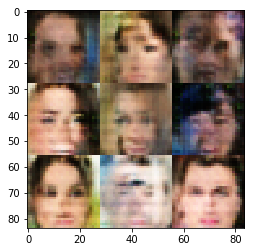

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


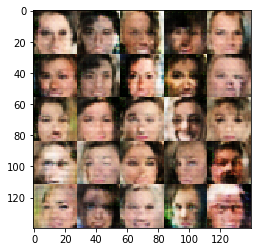

Global Step 2210 Epoch 1/1... Discriminator Loss: 1.39502931... Generator Loss: 0.72075546
Global Step 2220 Epoch 1/1... Discriminator Loss: 1.36452794... Generator Loss: 0.96838111
Global Step 2230 Epoch 1/1... Discriminator Loss: 1.46835411... Generator Loss: 0.62176275
Global Step 2240 Epoch 1/1... Discriminator Loss: 1.44555521... Generator Loss: 0.67617738
Global Step 2250 Epoch 1/1... Discriminator Loss: 1.48162115... Generator Loss: 0.58795011
Global Step 2260 Epoch 1/1... Discriminator Loss: 1.35999012... Generator Loss: 0.75855982
Global Step 2270 Epoch 1/1... Discriminator Loss: 1.38357675... Generator Loss: 0.67195106
Global Step 2280 Epoch 1/1... Discriminator Loss: 1.49714696... Generator Loss: 0.91856647
Global Step 2290 Epoch 1/1... Discriminator Loss: 1.50785851... Generator Loss: 0.63703334
Global Step 2300 Epoch 1/1... Discriminator Loss: 1.35663605... Generator Loss: 0.78866291
Global Step 2310 Epoch 1/1... Discriminator Loss: 1.43805265... Generator Loss: 0.71573567

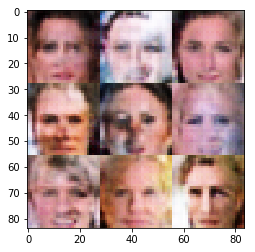

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


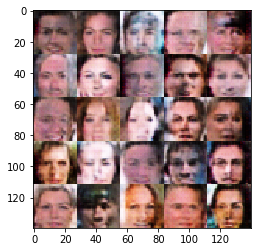

Global Step 2410 Epoch 1/1... Discriminator Loss: 1.38422680... Generator Loss: 0.78375554
Global Step 2420 Epoch 1/1... Discriminator Loss: 1.41153169... Generator Loss: 0.88239604
Global Step 2430 Epoch 1/1... Discriminator Loss: 1.43447423... Generator Loss: 0.65353298
Global Step 2440 Epoch 1/1... Discriminator Loss: 1.38724422... Generator Loss: 0.76470655
Global Step 2450 Epoch 1/1... Discriminator Loss: 1.38714242... Generator Loss: 0.76409769
Global Step 2460 Epoch 1/1... Discriminator Loss: 1.45802999... Generator Loss: 0.57574880
Global Step 2470 Epoch 1/1... Discriminator Loss: 1.43644607... Generator Loss: 0.75343025
Global Step 2480 Epoch 1/1... Discriminator Loss: 1.48714614... Generator Loss: 0.66915768
Global Step 2490 Epoch 1/1... Discriminator Loss: 1.36878467... Generator Loss: 0.70296979
Global Step 2500 Epoch 1/1... Discriminator Loss: 1.42095256... Generator Loss: 0.80740714
Global Step 2510 Epoch 1/1... Discriminator Loss: 1.32926250... Generator Loss: 0.81866038

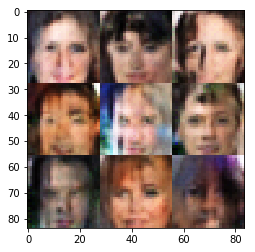

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


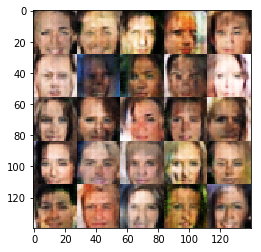

Global Step 2610 Epoch 1/1... Discriminator Loss: 1.34482157... Generator Loss: 0.79779470
Global Step 2620 Epoch 1/1... Discriminator Loss: 1.35320759... Generator Loss: 0.72578669
Global Step 2630 Epoch 1/1... Discriminator Loss: 1.37869394... Generator Loss: 0.81481636
Global Step 2640 Epoch 1/1... Discriminator Loss: 1.49132395... Generator Loss: 0.78670251
Global Step 2650 Epoch 1/1... Discriminator Loss: 1.39713323... Generator Loss: 0.70015812
Global Step 2660 Epoch 1/1... Discriminator Loss: 1.39830577... Generator Loss: 0.64724636
Global Step 2670 Epoch 1/1... Discriminator Loss: 1.41479933... Generator Loss: 0.76212013
Global Step 2680 Epoch 1/1... Discriminator Loss: 1.37522626... Generator Loss: 0.82834953
Global Step 2690 Epoch 1/1... Discriminator Loss: 1.52764463... Generator Loss: 0.75120646
Global Step 2700 Epoch 1/1... Discriminator Loss: 1.45927310... Generator Loss: 0.79546332
Global Step 2710 Epoch 1/1... Discriminator Loss: 1.47575617... Generator Loss: 0.81607509

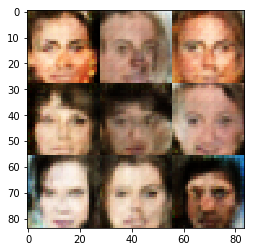

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


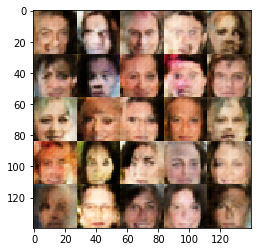

Global Step 2810 Epoch 1/1... Discriminator Loss: 1.40005541... Generator Loss: 0.80455399
Global Step 2820 Epoch 1/1... Discriminator Loss: 1.44712543... Generator Loss: 0.70594633
Global Step 2830 Epoch 1/1... Discriminator Loss: 1.45894027... Generator Loss: 0.64725518
Global Step 2840 Epoch 1/1... Discriminator Loss: 1.47680831... Generator Loss: 0.87659794
Global Step 2850 Epoch 1/1... Discriminator Loss: 1.51612365... Generator Loss: 0.69515836
Global Step 2860 Epoch 1/1... Discriminator Loss: 1.46641159... Generator Loss: 0.61673027
Global Step 2870 Epoch 1/1... Discriminator Loss: 1.29930699... Generator Loss: 0.81413746
Global Step 2880 Epoch 1/1... Discriminator Loss: 1.43419707... Generator Loss: 0.73814434
Global Step 2890 Epoch 1/1... Discriminator Loss: 1.37570322... Generator Loss: 0.77682096
Global Step 2900 Epoch 1/1... Discriminator Loss: 1.44171834... Generator Loss: 0.76024640
Global Step 2910 Epoch 1/1... Discriminator Loss: 1.41877365... Generator Loss: 0.76325315

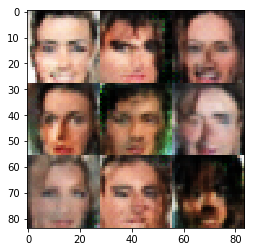

conv_transpose layer shape (?, 7, 7, 512)
conv_transpose layer shape (?, 14, 14, 256)
conv_transpose layer shape (?, 28, 28, 128)
conv_transpose layer shape (?, 28, 28, 3)


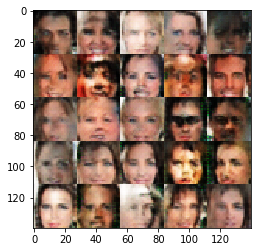

Global Step 3010 Epoch 1/1... Discriminator Loss: 1.51038146... Generator Loss: 0.53678763
Global Step 3020 Epoch 1/1... Discriminator Loss: 1.32835114... Generator Loss: 0.69598913
Global Step 3030 Epoch 1/1... Discriminator Loss: 1.47055948... Generator Loss: 0.74386799
Global Step 3040 Epoch 1/1... Discriminator Loss: 1.44574177... Generator Loss: 0.91869986
Global Step 3050 Epoch 1/1... Discriminator Loss: 1.40828776... Generator Loss: 0.75640845
Global Step 3060 Epoch 1/1... Discriminator Loss: 1.47914982... Generator Loss: 0.83840901
Global Step 3070 Epoch 1/1... Discriminator Loss: 1.36322403... Generator Loss: 0.64835060
Global Step 3080 Epoch 1/1... Discriminator Loss: 1.45953834... Generator Loss: 0.71255815
Global Step 3090 Epoch 1/1... Discriminator Loss: 1.40220308... Generator Loss: 0.80968887
Global Step 3100 Epoch 1/1... Discriminator Loss: 1.43743169... Generator Loss: 0.69875109
Global Step 3110 Epoch 1/1... Discriminator Loss: 1.39245534... Generator Loss: 0.68553412

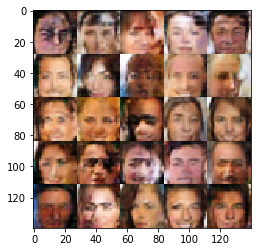

In [13]:
# same as mnist
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.